**Wine Dataset**

Niher Ronjon Pramanik

ID : 0242310005341102

SEC : F-1

# **Dataset Assign**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, sys
file_id = "1gJO729q2mUayPsff6Q9iH3PE931meG-d"
downloaded_name = "dataset_downloaded"

import subprocess, shlex
try:
    !gdown --id {file_id} -O {downloaded_name} || true
except Exception as e:
    print("gdown attempt failed:", e)

candidates = [f for f in os.listdir('.') if f.startswith(downloaded_name)]
print("Downloaded candidates:", candidates)

if len(candidates) == 0:
    print("No file was downloaded.")
DATASET_PATH = None

if len(candidates) > 0:
    DATASET_PATH = candidates[0]
    print("Using downloaded file:", DATASET_PATH)

if DATASET_PATH is None:
    DATASET_PATH = "/content/drive/MyDrive/dataset.csv"
    print("Fallback DATASET_PATH:", DATASET_PATH)


/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1gJO729q2mUayPsff6Q9iH3PE931meG-d
To: /content/dataset_downloaded
100% 390k/390k [00:00<00:00, 98.3MB/s]
Downloaded candidates: ['dataset_downloaded']
Using downloaded file: dataset_downloaded


# **2. Imports**

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.metrics import (confusion_matrix, classification_report, roc_curve, auc,
                             roc_auc_score, precision_recall_fscore_support, accuracy_score)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# **3. Load dataset (autometicly detect CSV)**

In [ ]:
def load_dataset(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Dataset not found at: {path}")
    try:
        df = pd.read_csv(path)
        print("Loaded CSV with shape:", df.shape)
        return df
    except Exception as e_csv:
        try:
            df = pd.read_excel(path, engine='openpyxl')
            print("Loaded Excel with shape:", df.shape)
            return df
        except Exception as e_xls:
            raise ValueError(f"Failed to read dataset as CSV or Excel. CSV error: {e_csv}; Excel error: {e_xls}")

try:
    df = load_dataset(DATASET_PATH)
except Exception as e:
    print("Error loading dataset:", e)
    raise
print("\nFirst five rows:")
display(df.head())
print("\nDataset info:")
display(df.info())
print("\nMissing values per column:")
display(df.isnull().sum())

Loaded CSV with shape: (6497, 13)

First five rows:


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


None


Missing values per column:


,0
type,0
fixed acidity,10
volatile acidity,8
citric acid,3
residual sugar,2
chlorides,2
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,9


# **4. Detect target column**

In [ ]:
possible_targets = ['target','label','class','Class','y','Y','Outcome','outcome']
target_col = None
for name in possible_targets:
    if name in df.columns:
        target_col = name
        break
if target_col is None:
    target_col = df.columns[-1]
print("Auto-detected target column:", target_col)
print("Unique values (up to 20):", df[target_col].unique()[:20])
print("Number of unique labels:", df[target_col].nunique())

Auto-detected target column: quality
Unique values (up to 20): [6 5 7 8 4 3 9]
Number of unique labels: 7


# **5. Data cleaning and preprocessing**

# **5.1 Remove exact duplicates**

In [ ]:
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"Removed {before-after} duplicate rows. New shape: {df.shape}")

Removed 1168 duplicate rows. New shape: (5329, 13)


# **5.2 Attempt numeric coercion on object columns (except target)**

In [ ]:
for col in df.columns:
    if col == target_col:
        continue
    if df[col].dtype == object:
        # try to coerce to numeric where possible
        df[col] = pd.to_numeric(df[col].str.replace(',',''), errors='ignore')

# **5.3 Report missing values and handle them**

In [ ]:
print("Missing values before imputation:")
display(df.isnull().sum())

Missing values before imputation:


,0
type,0
fixed acidity,10
volatile acidity,8
citric acid,3
residual sugar,2
chlorides,2
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,9


## **Identify numeric and categorical feature columns**

In [ ]:
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
if target_col in numeric_cols:
    numeric_cols = [c for c in numeric_cols if c != target_col]
categorical_cols = [c for c in df.columns if c not in numeric_cols + [target_col]]

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

Numeric columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Categorical columns: ['type']


**Impute numeric -> mean, categorical -> most frequent**

In [ ]:
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

if numeric_cols:
    df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])
if categorical_cols:
    df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

# **Drop rows with missing target if any.**

In [ ]:
if df[target_col].isnull().sum() > 0:
    df = df.dropna(subset=[target_col])
    print("Dropped rows with missing target. New shape:", df.shape)

print("Missing values after imputation:")
display(df.isnull().sum())

Missing values after imputation:


,0
type,0
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0


# **6. Encode target and features**

In [ ]:
le_target = LabelEncoder()
if df[target_col].dtype == object or df[target_col].nunique() <= 50:
    y = le_target.fit_transform(df[target_col].astype(str))
    print("Target label-encoded. Classes:", list(le_target.classes_))
else:

    y = df[target_col].values
    print("Target appears numeric/continuous. If you intended classification, convert target to categorical first.")
X = df.drop(columns=[target_col]).copy()
cat_features = X.select_dtypes(include=['object','category','bool']).columns.tolist()
int_like = [c for c in X.select_dtypes(include=['int','int64','Int64']).columns.tolist() if X[c].nunique() <= 10]
for c in int_like:
    if c not in cat_features:
        cat_features.append(c)
binary_cols = [c for c in cat_features if X[c].nunique() == 2]
multi_cols = [c for c in cat_features if X[c].nunique() > 2]
print("Binary categorical columns:", binary_cols)
print("Multi-class categorical columns:", multi_cols)

transformers = []
if binary_cols:
    transformers.append(('bin', OrdinalEncoder(), binary_cols))
if multi_cols:
    transformers.append(('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False), multi_cols))

remainder_cols = [c for c in X.columns if c not in binary_cols + multi_cols]
if transformers:
    ct = ColumnTransformer(transformers=transformers, remainder='passthrough')
    X_trans = ct.fit_transform(X)
    feature_names = []
    if multi_cols:
        ohe = ct.named_transformers_['ohe']
        ohe_names = ohe.get_feature_names_out(multi_cols).tolist()
        feature_names.extend(ohe_names)
    if binary_cols:
        feature_names.extend(binary_cols)
    feature_names.extend(remainder_cols)
    X = pd.DataFrame(X_trans, columns=feature_names)
else:
    X = X.reset_index(drop=True)

print("Feature matrix shape after encoding:", X.shape)

Target label-encoded. Classes: ['3', '4', '5', '6', '7', '8', '9']
Binary categorical columns: ['type']
Multi-class categorical columns: []
Feature matrix shape after encoding: (5329, 12)


# **7. Feature scaling**

In [ ]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X = X_scaled.copy()
print("Features scaled with StandardScaler.")

Features scaled with StandardScaler.


# **8. Train-test split (80/20)**

In [ ]:
stratify_param = y if (isinstance(y, np.ndarray) and len(np.unique(y)) <= 50) else None
X, y = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=stratify_param)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (4263, 12) Test shape: (1066, 12)


# **9. Define models five classifiers models and train**

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42)
}

fitted_models = {}
predictions = {}
probabilities = {}

for name, clf in models.items():
    print(f"Training model: {name} ...")
    clf.fit(X_train, y_train)
    fitted_models[name] = clf
    predictions[name] = clf.predict(X_test)
    try:
        proba = clf.predict_proba(X_test)
        probabilities[name] = proba
    except Exception:
        try:
            dfun = clf.decision_function(X_test)
            if dfun.ndim == 1:
                dfun_scaled = (dfun - dfun.min()) / (dfun.max() - dfun.min() + 1e-12)
                probabilities[name] = np.vstack([1-dfun_scaled, dfun_scaled]).T
            else:
                from scipy.special import softmax
                probabilities[name] = softmax(dfun, axis=1)
        except Exception:
            probabilities[name] = None
    print(f"{name} trained.")

print("All models trained.")

Training model: Logistic Regression ...
Logistic Regression trained.
Training model: K-Nearest Neighbors ...
K-Nearest Neighbors trained.
Training model: Decision Tree ...
Decision Tree trained.
Training model: Random Forest ...
Random Forest trained.
Training model: Support Vector Machine ...
Support Vector Machine trained.
All models trained.


# **10. Evaluate models: classification report and confusion matrix**


Model: Logistic Regression
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         5
           1     0.4000    0.0571    0.1000        35
           2     0.5954    0.5971    0.5963       350
           3     0.5408    0.6881    0.6057       481
           4     0.5714    0.3256    0.4148       172
           5     0.0000    0.0000    0.0000        20
           6     0.0000    0.0000    0.0000         3

    accuracy                         0.5610      1066
   macro avg     0.3011    0.2383    0.2453      1066
weighted avg     0.5449    0.5610    0.5393      1066



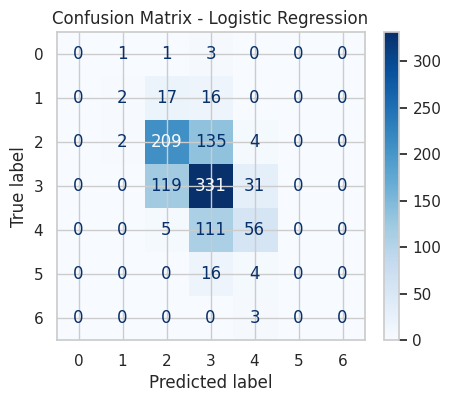


Model: K-Nearest Neighbors
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         5
           1     0.3333    0.2000    0.2500        35
           2     0.5254    0.5914    0.5565       350
           3     0.5573    0.5967    0.5763       481
           4     0.4882    0.3605    0.4147       172
           5     0.1250    0.0500    0.0714        20
           6     0.0000    0.0000    0.0000         3

    accuracy                         0.5291      1066
   macro avg     0.2899    0.2569    0.2670      1066
weighted avg     0.5160    0.5291    0.5192      1066



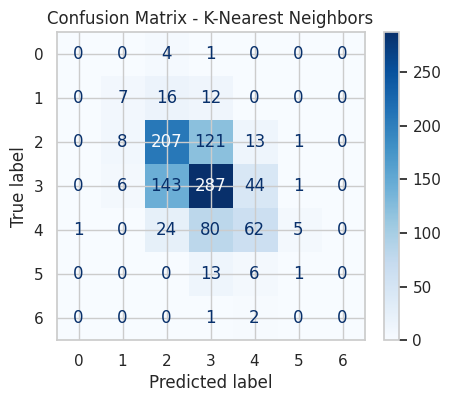


Model: Decision Tree
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         5
           1     0.1463    0.1714    0.1579        35
           2     0.5000    0.4800    0.4898       350
           3     0.5130    0.4906    0.5016       481
           4     0.3672    0.3779    0.3725       172
           5     0.0625    0.1500    0.0882        20
           6     0.0000    0.0000    0.0000         3

    accuracy                         0.4484      1066
   macro avg     0.2270    0.2386    0.2300      1066
weighted avg     0.4609    0.4484    0.4541      1066



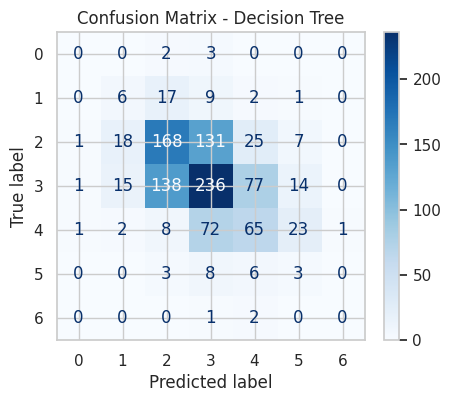


Model: Random Forest
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         5
           1     0.4444    0.1143    0.1818        35
           2     0.6340    0.6286    0.6313       350
           3     0.5780    0.7089    0.6368       481
           4     0.5739    0.3837    0.4599       172
           5     0.4000    0.1000    0.1600        20
           6     0.0000    0.0000    0.0000         3

    accuracy                         0.5938      1066
   macro avg     0.3758    0.2765    0.2957      1066
weighted avg     0.5837    0.5938    0.5778      1066



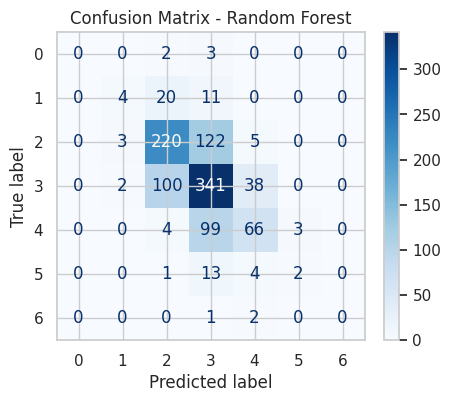


Model: Support Vector Machine
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         5
           1     0.0000    0.0000    0.0000        35
           2     0.5918    0.6171    0.6042       350
           3     0.5417    0.7152    0.6165       481
           4     0.6212    0.2384    0.3445       172
           5     0.0000    0.0000    0.0000        20
           6     0.0000    0.0000    0.0000         3

    accuracy                         0.5638      1066
   macro avg     0.2507    0.2244    0.2236      1066
weighted avg     0.5390    0.5638    0.5321      1066



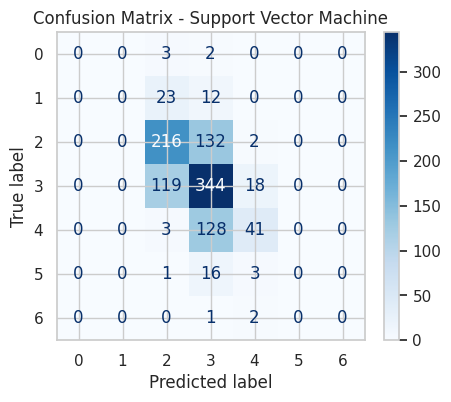

In [ ]:
for name in models.keys():
    print("\n" + "="*40)
    print("Model:", name)
    print(classification_report(y_test, predictions[name], digits=4))
    cm = confusion_matrix(y_test, predictions[name])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(5,4))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'Confusion Matrix - {name}')
    plt.show()

# **11. ROC Curves (binary and multiclass handling)**

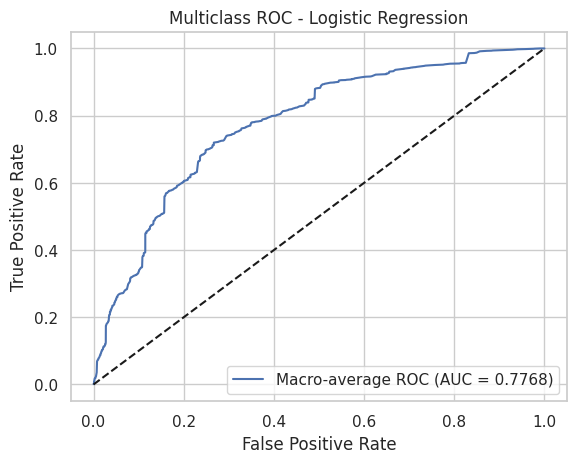

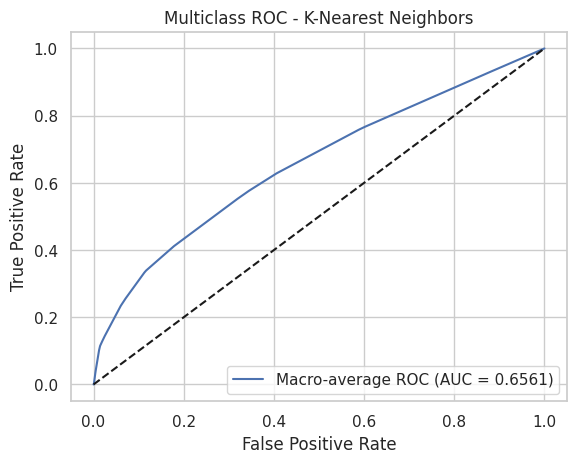

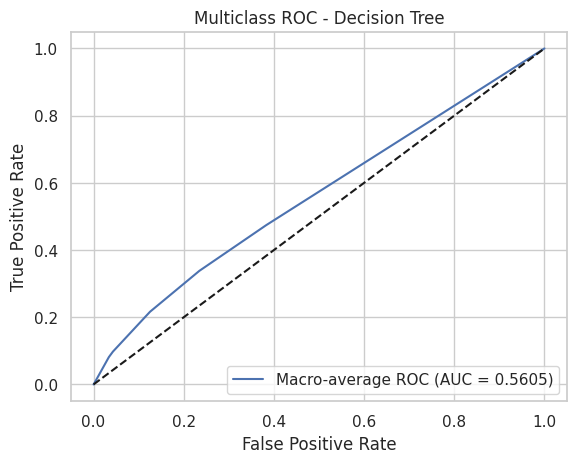

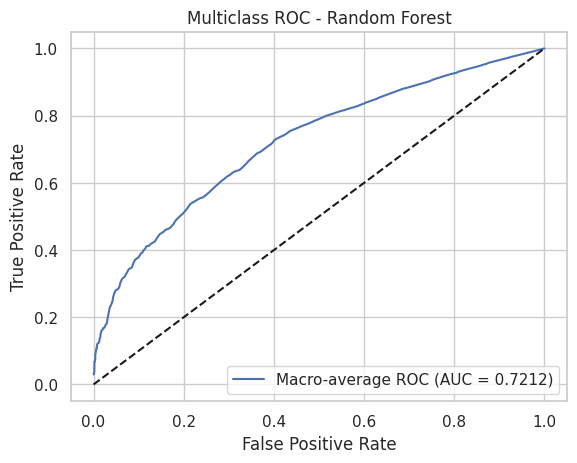

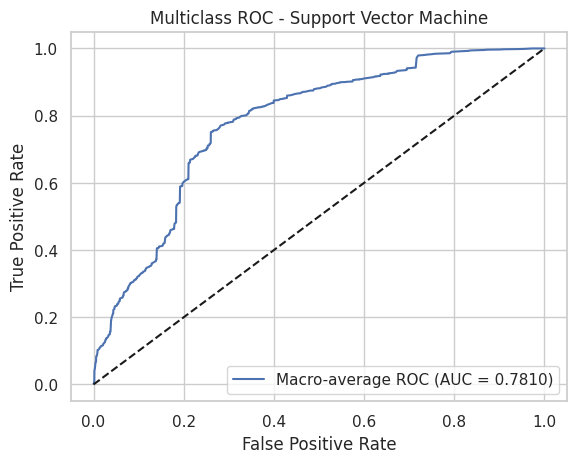

In [ ]:
def plot_roc_curve(y_true, y_score, model_name):
    classes = np.unique(y_true)
    if len(classes) == 2:
        if y_score is None:
            print(f"Skipping ROC for {model_name} (no score/probabilities).")
            return
        if y_score.ndim == 2 and y_score.shape[1] == 2:
            pos_score = y_score[:,1]
        elif y_score.ndim == 1:
            pos_score = y_score
        else:
            pos_score = y_score[:,1]
        fpr, tpr, _ = roc_curve(y_true, pos_score)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')
        plt.plot([0,1],[0,1],'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc='lower right')
        plt.show()
    else:
        if y_score is None:
            print(f"Skipping multiclass ROC for {model_name} (no probability outputs).")
            return
        try:
            from sklearn.preprocessing import label_binarize
            y_bin = label_binarize(y_true, classes=classes)
            n_classes = y_bin.shape[1]
            if y_score.ndim == 1:
                print(f"Unexpected shape for y_score for multiclass model {model_name}.")
                return
            fpr = dict(); tpr = dict(); roc_auc = dict()
            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])
            all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
            mean_tpr = np.zeros_like(all_fpr)
            for i in range(n_classes):
                mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
            mean_tpr /= n_classes
            roc_auc["macro"] = auc(all_fpr, mean_tpr)
            plt.figure()
            plt.plot(all_fpr, mean_tpr, label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.4f})')
            plt.plot([0,1],[0,1],'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Multiclass ROC - {model_name}')
            plt.legend(loc='lower right')
            plt.show()
        except Exception as e:
            print("Failed to compute multiclass ROC for", model_name, ":", e)
for name in models.keys():
    plot_roc_curve(y_test, probabilities.get(name, None), name)

# **12. Learning curves for each model.**

Plotting learning curve for: Logistic Regression


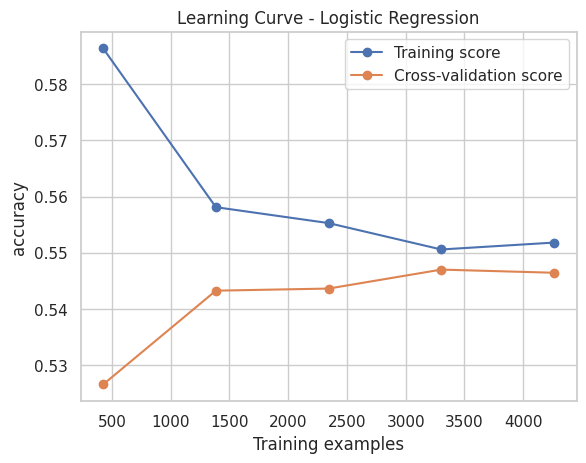

Plotting learning curve for: K-Nearest Neighbors


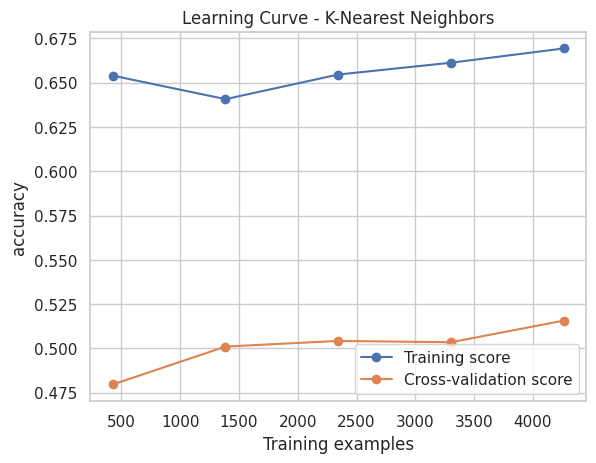

Plotting learning curve for: Decision Tree


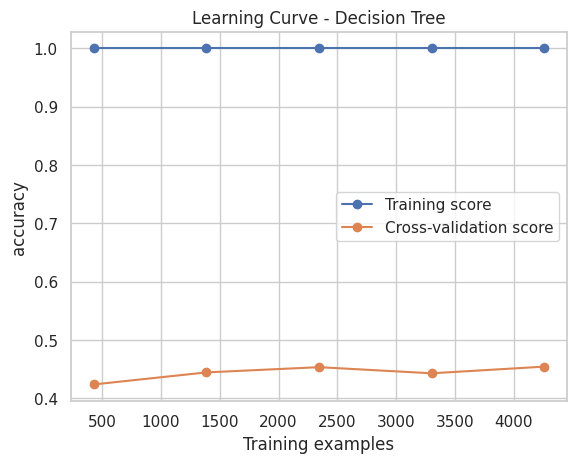

Plotting learning curve for: Random Forest


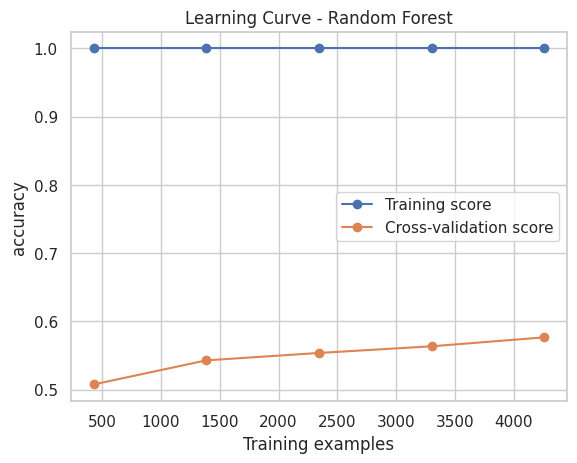

Plotting learning curve for: Support Vector Machine


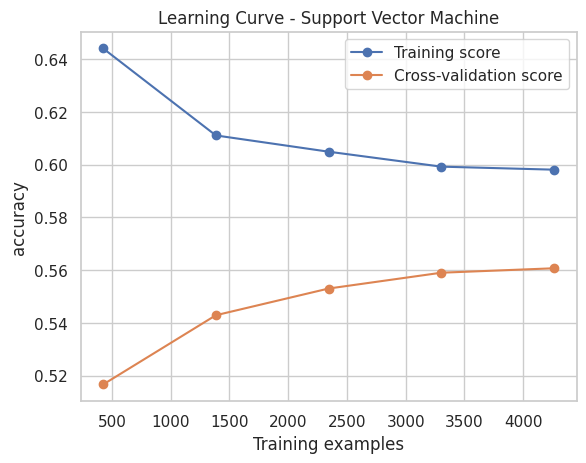

In [ ]:
def plot_learning_curve(estimator, title, X_data, y_data, cv=5, scoring='accuracy'):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X_data, y_data, cv=cv,
                                                            train_sizes=np.linspace(.1, 1.0, 5),
                                                            scoring=scoring, n_jobs=-1)
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    plt.figure()
    plt.plot(train_sizes, train_mean, 'o-', label='Training score')
    plt.plot(train_sizes, test_mean, 'o-', label='Cross-validation score')
    plt.title(title)
    plt.xlabel('Training examples')
    plt.ylabel(scoring)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

for name, clf in fitted_models.items():
    print("Plotting learning curve for:", name)
    plot_learning_curve(clf, f"Learning Curve - {name}", X, y, cv=5, scoring='accuracy')

# **13. Visualizations: feature distributions, correlation heatmap, scatter.**

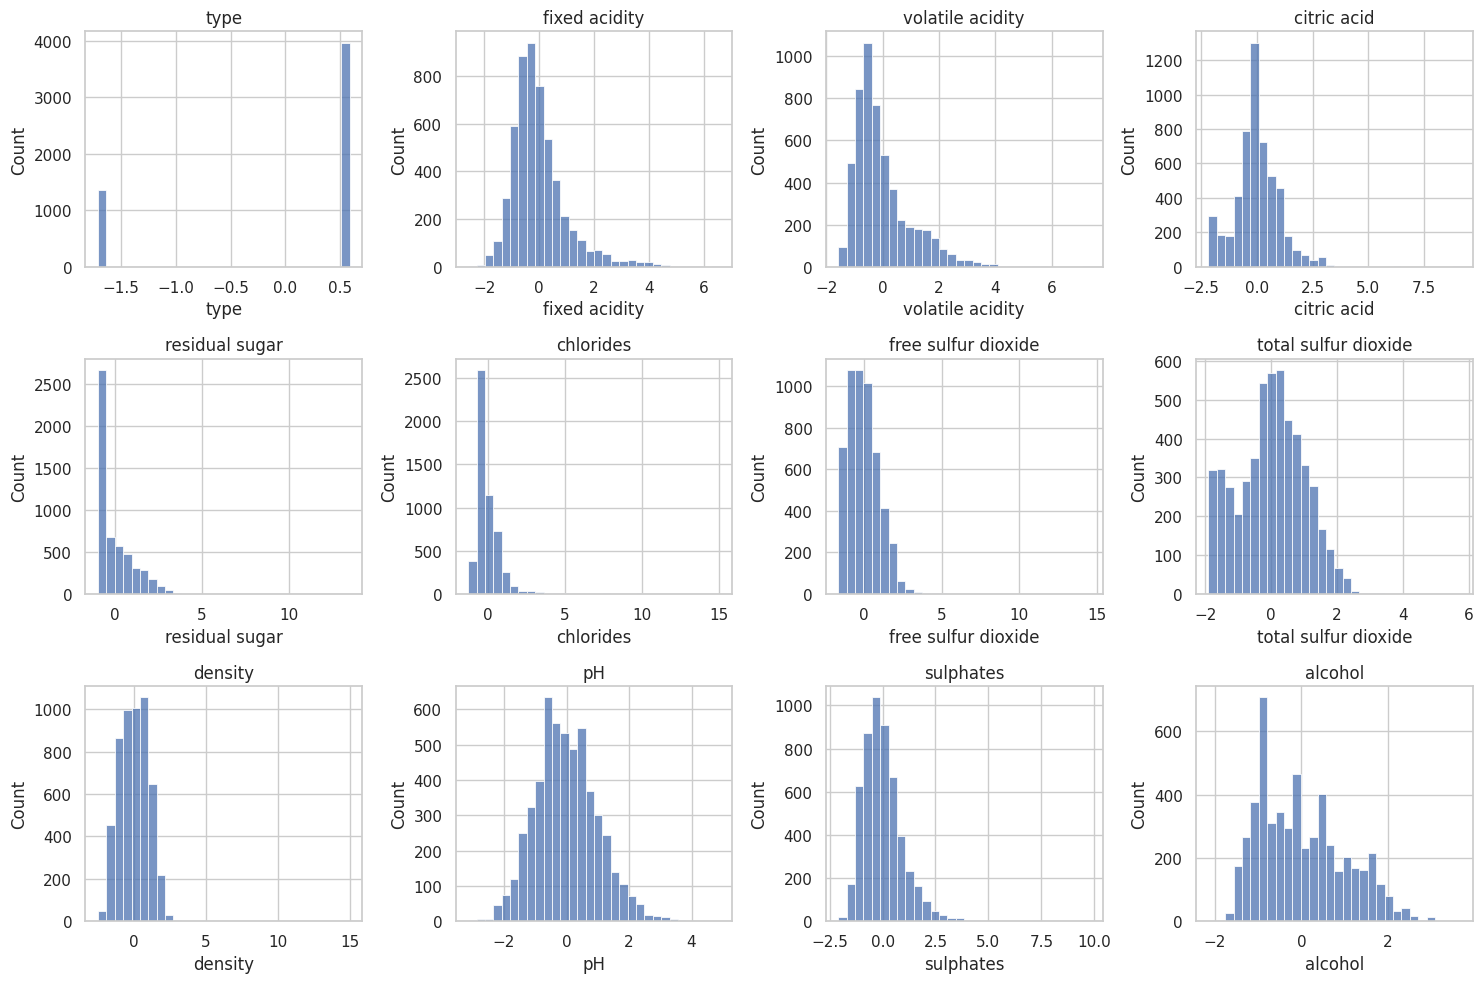

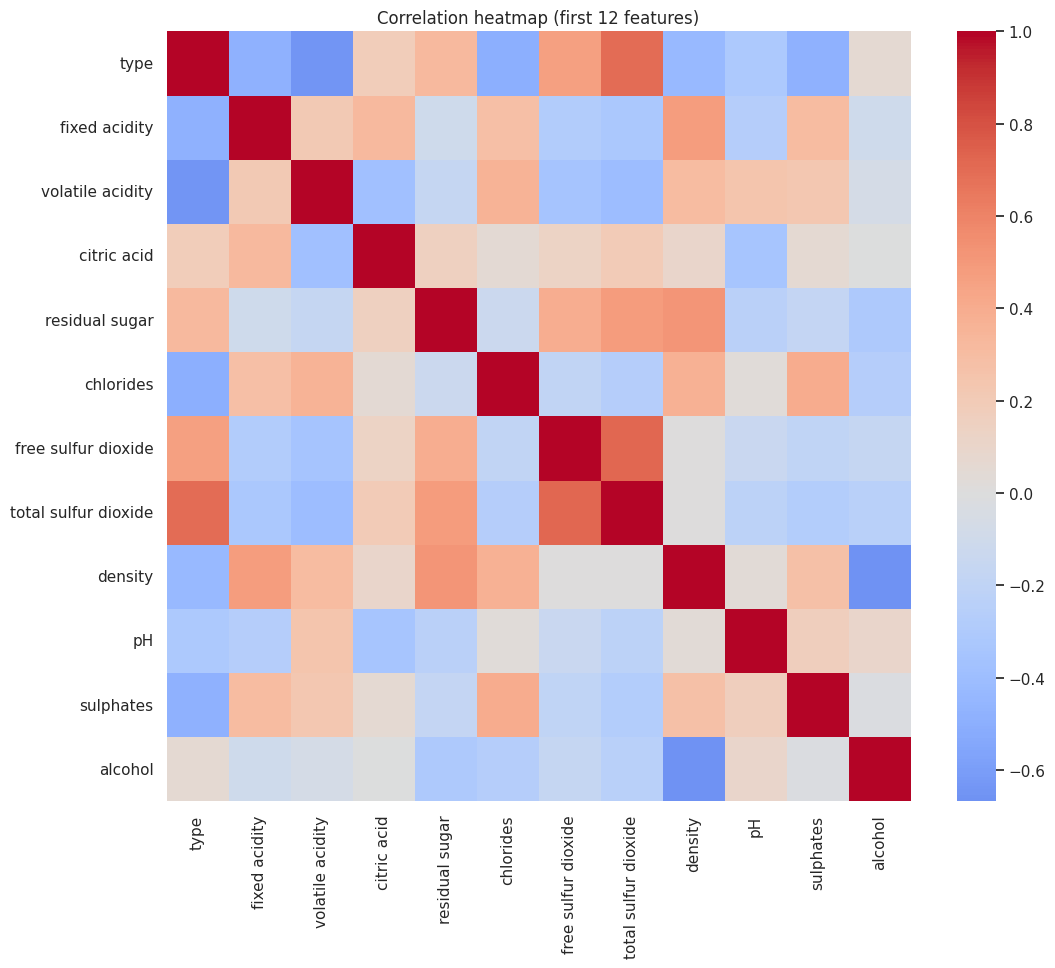

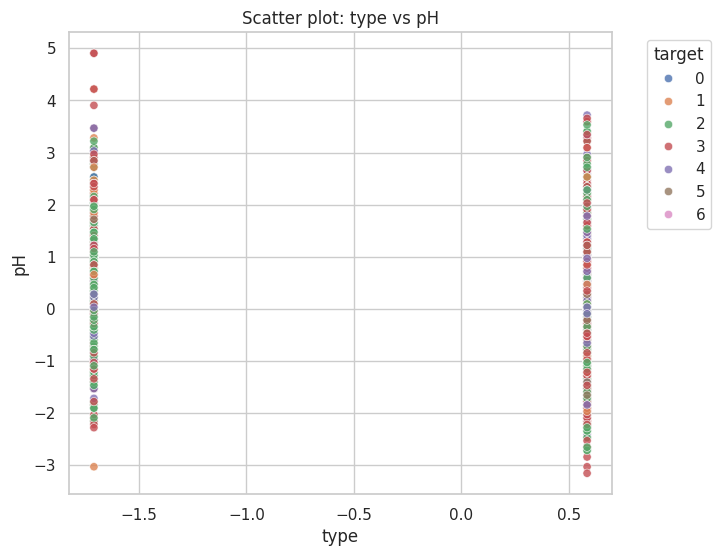

In [ ]:
n_features = min(12, X.shape[1])
plt.figure(figsize=(15, 10))
for i, col in enumerate(X.columns[:n_features], 1):
    plt.subplot((n_features+3)//4, 4, i)
    sns.histplot(X[col], bins=30, kde=False)
    plt.title(col)
plt.tight_layout()
plt.show()
topn = min(30, X.shape[1])
plt.figure(figsize=(12,10))
sns.heatmap(X.iloc[:, :topn].corr(), cmap='coolwarm', center=0)
plt.title("Correlation heatmap (first {} features)".format(topn))
plt.show()
variances = X.var().sort_values(ascending=False)
top_two = variances.index[:2].tolist()
if len(top_two) >= 2:
    plt.figure(figsize=(7,6))
    if len(np.unique(y)) <= 10:
        sns.scatterplot(x=X[top_two[0]], y=X[top_two[1]], hue=y, palette='deep', alpha=0.8)
        plt.legend(title='target', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        plt.scatter(X[top_two[0]], X[top_two[1]], alpha=0.6)
    plt.xlabel(top_two[0]); plt.ylabel(top_two[1])
    plt.title(f"Scatter plot: {top_two[0]} vs {top_two[1]}")
    plt.show()

# **14. Summarize and results:**

In [ ]:
results = []
for name in models.keys():
    acc = accuracy_score(y_test, predictions[name])
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, predictions[name], average='weighted', zero_division=0)
    auc_score = None
    proba = probabilities.get(name, None)
    try:
        if proba is not None:
            if len(np.unique(y_test)) == 2:
                auc_score = roc_auc_score(y_test, proba[:,1])
            else:
                auc_score = roc_auc_score(y_test, proba, multi_class='ovr')
    except Exception:
        auc_score = None
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1,
        "ROC-AUC": auc_score
    })

results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
display(results_df)
results_csv = "model_results_summary.csv"
results_df.to_csv(results_csv, index=False)
print("Saved results to", results_csv)

,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC
3,Random Forest,0.593809,0.583651,0.593809,0.577780,0.721173
4,Support Vector Machine,0.563790,0.538973,0.563790,0.532138,0.780502
0,Logistic Regression,0.560976,0.544877,0.560976,0.539286,0.776215
1,K-Nearest Neighbors,0.529081,0.516014,0.529081,0.519203,0.656068
2,Decision Tree,0.448405,0.460891,0.448405,0.454085,0.560459


Saved results to model_results_summary.csv
